## Purpose  
Demonstrate how leakage can be detected using a data randomization process.  
## Process
Create fake data using bernoulli GLM data-generating process (DGP). Intentionally leak information and then show that this code helps detect the leakage.

In [1]:
import pandas as pd
import sys
import numpy as np
import os
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import metrics 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')

In [2]:
# Set seed
np.random.seed(0)

In [3]:
def randomize(filepath, index_col = None, do_not_randomize = None):
    '''
    Randomize column values of a file. Each column is randomized independently.
    
    Inputs:
        filepath (str): path to file to randomize; may be of type csv or txt
        index_col (str): optional name of column to use as index; will not 
            be randomized
        do_not_randomize (list): optional list of strings indicating names of 
            columns that should not be randomized
    Outputs:
        df (dataframe): dataframe representation of randomized data
        Output file will be generated, named as original file name + "_randomized"
    '''
    
    # Treat csv and txt differently
    filename, file_extension = os.path.splitext(filepath)
    if file_extension == '.csv':
        sep = ","
    elif file_extension == '.txt':
        sep = "\t"
        
    # Randomize column by column
    df = pd.read_csv(filepath, sep = sep, index_col = index_col) 
    
    if do_not_randomize:
        cols = [c for c in df.columns if c not in do_not_randomize]
    else:
        cols = df.columns
        
    for col in cols:
        print('... Randomizing column ' + col)
        df[col] = np.random.permutation(df[col])
        
    # Print to new csv or txt
    new_file = filename + '_randomized' + file_extension
    df.to_csv(new_file)   
    
    return df

In [4]:
def generate_data(period, n_rows, m_columns, threshold, betas, intercept):
    '''
    Generate fake data for a classification task, based on data generating process where:
    - Features are drawn iid from standard normal distribution
    - Regression equation: y = intercept + beta_1 * x1 + .. + beta_m * xm + error
    - Error is drawn from standard normal distribution
    - Outcome is 1 if p value from logistic function exceeds threshold, 0 otherwise
    
    Inputs:
        period (int): time period
        n_rows (int): number of observations to generate
        m_columns (int): number of features to generate
        betas (list): list of numerical values to use as coefficients; length must equal m_columns, 
            i.e. don't include intercept
        intercept (int): constant number to use as intercept of regression equation
        
    Outputs:
        X (dataframe): matrix of feature variables
        y (series): outcome variable
    '''
    print("Generating {} observations...".format(n_rows))
    
    # generate column names
    colnames = []
    for i in range(m_columns):
        colnames.append('x' + str(i + 1))
    
    # generate fake data
    df = pd.DataFrame(np.random.normal(size=(n_rows, m_columns)), columns = colnames)
    df.insert(loc = 0, column = 'intercept', value = intercept)
    betas = [1] + betas
    df['z'] = np.multiply(np.array(betas), df).sum(axis=1) + np.random.normal()
    df['pr'] = df['z'].apply(lambda x: 1/(1 + math.exp(x)))
    df['outcome'] = np.where(df['pr'] > threshold, 1, 0)
    df.index.name = 'idx'
    df['period'] = period
    
    return df

In [5]:
def run_logreg(X_train, y_train, X_test, y_test, plot = True):
    '''
    Run logistic regression on given test and training sets   
    
    Inputs
        training and test sets
    
    Output
        dictionary containing logistic regresison model, test set, and evaluation metrics
    '''
    print("Baseline accuracy: " + str(round(1 - np.mean(y_train), 3)))
    
    # Create a logistic regression object
    logreg = linear_model.LogisticRegression()

    # Train model with training set
    logreg.fit(X_train, y_train)

    # Make predictions with test set
    y_pred = logreg.predict(X_test)

    # Save probabilities
    probs = logreg.predict_proba(X_test)
    
    # Caluclate accuracy and AUC
    accuracy = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, probs[:, 1])
    
    # Print accuracy and AUC
    print("Accuracy: " + str(round(accuracy, 3)))
    print("AUC Score: " + str(round(auc, 3)))

    # Print confusion matrix
    print(metrics.confusion_matrix(y_test, y_pred))
    
    if plot:
        # Plot AUC curve (source: https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/)
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
        roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([-0.1,1.2])
        plt.ylim([-0.1,1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    # Create output dictionary
    output = {'model': logreg, 'X_test': X_test, 'y_test': y_test, 'y_pred': y_pred, 'probs': probs, 'accuracy': accuracy, 'auc': auc}
    
    return output

In [6]:
def get_X_y(df):
    '''
    Split data frame into X and y objects 
    '''
    X = df.drop(['z', 'pr', 'outcome'], axis = 1)
    y = df['outcome']
    return X, y

def logreg_pipeline(df, temporal = False, plot = True):
    '''
    Put raw inputs through basic machine learning pipeline.
    
    Inputs:
        df (dataframe): Pandas dataframe representing raw input file
        temporal (bool): Indicator for whether a temporal TimeSeriesSplit
            should be use instead of non-temporal train_test_split
        plot (bool): Indicator for whether to plot the auc curve
    OUtputs:
        list of logistic regression model dictionaries
    '''
    # Save results of run_logreg
    models = []
    
    # Split into train and test sets
    if temporal: # do temporal train-test split
        periods = np.sort(df.period.unique())
        splits = TimeSeriesSplit(n_splits = max(periods))
        print("\nTime series split")
        for train_index, test_index in splits.split(periods):
            print("Train periods: ", train_index, "Test periods: ", test_index)
            df_train = df[df.period.isin(train_index)]
            df_test = df[df.period.isin(test_index)]
            X_train, y_train = get_X_y(df_train)
            X_test, y_test = get_X_y(df_test)
            models.append(run_logreg(X_train, y_train, X_test, y_test, plot))

    else: # do random, non-temporal train-test split
        print("\nTrain test split -- test size = 0.33")
        X, y = get_X_y(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        models.append(run_logreg(X_train, y_train, X_test, y_test, plot))
    
    return models

In [7]:
def bootstrap_auc1(df, bootstrap_n, temporal = False):
    '''
    Run logistic regression pipeline a number of times to obtain a distribution of AUC scores for significance testing
    
    NOTE: Currently doesn't work for temporal = True
    
    Inputs
        df (dataframe): Pandas dataframe representing raw input file
        bootstrap_n (int): number of bootstrap samples to run
        temporal (bool): Indicator for whether a temporal TimeSeriesSplit
            should be use instead of non-temporal train_test_split
        
    Outputs
        auc_array (array): array of dimension bootstrap_n x num_temporal_tests
    '''
    all_iterations = []
    for n in range(bootstrap_n):
        all_iterations.append(logreg_pipeline(df, temporal, plot = False))
    
    if temporal: 
        auc_scores = [[d['auc'] for d in iteration] for iteration in all_iterations]
        auc_array = np.array(auc_scores)
    else: 
        auc_scores = np.array([iteration[0]['auc'] for iteration in all_iterations])
        auc_array = np.array(auc_scores)[:,np.newaxis]
    
    return auc_array

In [8]:
def bootstrap_auc2(models, bootstrap_n, temporal = False):
    '''
    Sample with replacement from test set a number of times to obtain a distribution of AUC scores for significance testing
    
    Currently doesn't work for temporal = True
    
    Inputs
        models (list): list of modelso outputted from logreg_pipeline
        bootstrap_n (int): number of bootstrap samples to run
        temporal (bool): Indicator for whether a temporal TimeSeriesSplit
            should be use instead of non-temporal train_test_split
            
    Outputs
        auc_array (array): array of dimension bootstrap_n x num_temporal_tests
    '''
    ls = []
    for m in models:
        # create test dataframe and sample from it
        y_test = m['y_test']
        probs = m['probs'][:, 1]
        test_set = pd.DataFrame(y_test)
        test_set['probs'] = probs
        aucs = []
        for n in range(bootstrap_n):
            sample = test_set.sample(frac = 0.5, replace=True)
            auc = metrics.roc_auc_score(sample['outcome'], sample['probs'])
            aucs.append(auc)
        ls.append(aucs)
    auc_array = np.array(ls)
    return auc_array

In [9]:
def check_significance(auc_scores, m):
    '''
    Use two one-sided significance test (TOST) to check for negligible effect, as described here: 
        http://www.carlislerainey.com/papers/nme.pdf
    
    Goal: argue for an empirically negligible effect, i.e. AUC score is no different from random
    H0: AUC is in [0, 0.5 - m] U [0.5 + m, 1], i.e. score is different from random
    H1: AUC is in [0.5 - m, 0.5 + m]
    
    p-value of a TOST is the maximum of the p-values of each one-sided test
    We reject null at significance level of alpha = 0.05 
    
    Inputs
        auc_scores (list): list of auc scores from bootstrapped samples
        m (float):  Assuming that the smallest substantially meaningful effect for results to be different from random
            is when AUC is m different from 0.5 (random).
            
    Outputs
        p (float): p value / significance level
    '''    
    sample_mean = np.mean(auc_scores)
    std_error = np.std(auc_scores, ddof=1) # unbiased estimator
    deg = len(auc_scores) - 1
    print("Sample mean: ", round(sample_mean,6))
    print("Standard error: ", round(std_error,6))
    
    # Compute p-val for side 1: AUC is in [0, 0.5 - m]
    t1 = (sample_mean - (0.5 - m)) / std_error
    p1 = stats.t.cdf(x = abs(t1), df = deg)
    
    # Compute p-val for side 2: AUC is in [0.5 + m, 1]
    t2 = (sample_mean - (0.5 + m)) / std_error
    p2 = stats.t.cdf(x = abs(t2), df = deg)
    
    # p-val is max of the two one-sided tests
    p = max(p1, p2)
    
    # reject null if 1-p <= 0.05, i.e. significance level of 0.05 or lower is achieved
    if p >= 0.95:
        print('Reject null at significance level ', 1-p)
    else:
        print('Fail to reject null atsignificance level ', 1-p)
    
    return p

## Case 1: Stable DGP 
### Non-temporal example with stable DGP; data leakage through outcome variable as a feature

Generate data for 5 periods with constant DGP

In [10]:
frames = []
for i in range(5):
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 5, threshold = 0.8, betas = [1,2,3,4,5], intercept = 1)
    frames.append(period_df)
df = pd.concat(frames)
df.to_csv('fake_data.csv')

Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...


Run original input file through pipeline.


Train test split -- test size = 0.33
Baseline accuracy: 0.596
Accuracy: 0.976
AUC Score: 0.998
[[1911   42]
 [  36 1311]]


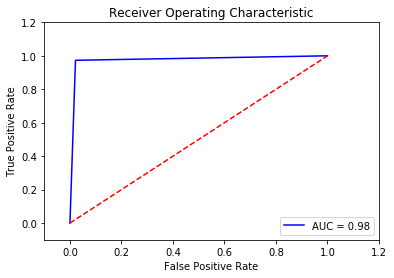

In [11]:
models = logreg_pipeline(df)

Put the input file through randomization process, then run it through the pipeline.

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Train test split -- test size = 0.33
Baseline accuracy: 0.597
Accuracy: 0.591
AUC Score: 0.526
[[1951    0]
 [1349    0]]


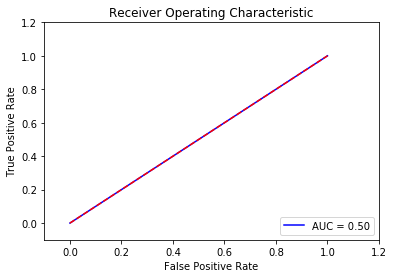

In [12]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # creates csv named fake_data_randomized.csv
models = logreg_pipeline(df_random)

Perform statistical test on AUC to confirm that model performs no better than random.

In [13]:
%%capture
auc_array = bootstrap_auc1(df_random, 1000, temporal=False)

In [14]:
check_significance(auc_array, m = 0.05)

Sample mean:  0.531298
Standard error:  0.008175
Reject null at significance level  0.0


1.0

Try introducing an obvious case of data leakage by using the outcome column as a feature. Run this through the pipeline. Model performs well, as expected.


Train test split -- test size = 0.33
Baseline accuracy: 0.595
Accuracy: 1.0
AUC Score: 1.0
[[1962    0]
 [   0 1338]]


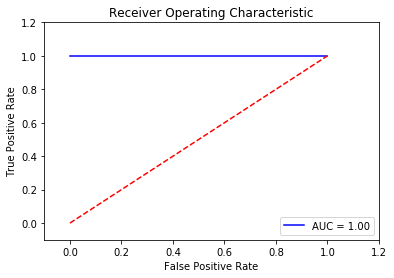

In [15]:
df['leaky_col'] = df['outcome']
models = logreg_pipeline(df)

Put the input file through randomization process. Again, introduce data leakage into the pipeline.

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Train test split -- test size = 0.33
Baseline accuracy: 0.597
Accuracy: 1.0
AUC Score: 1.0
[[1951    0]
 [   0 1349]]


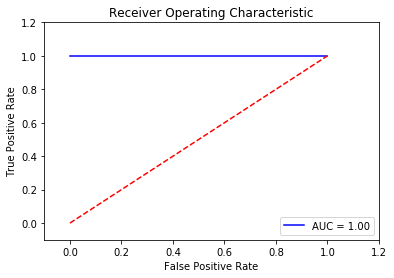

In [16]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # generates csv named "fake_data_randomized.csv"
df_random['leaky_col'] = df_random['outcome']
models = logreg_pipeline(df_random)

Perform statistical test on AUC to confirm that model performs better than random, thus suggesting the existence of data leakage.

In [17]:
%%capture
auc_array = bootstrap_auc1(df_random, 1000, temporal=False)

In [18]:
check_significance(auc_array, m = 0.05)

Sample mean:  1.0
Standard error:  0.0
Reject null at significance level  0.0


C:\Users\JoanWang\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


1.0

## Case 2: Stable DGP
### Non-temporal example with stable DGP; data leakage through selection of variables that are highly correlated with outcome (i.e. proxy variables)

Generate data with 1000 variables for 5 periods with constant DGP. Betas are random integers between 0 and 10.

In [19]:
frames = []
for i in range(5):
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 1000, threshold = 0.8, betas = list(np.random.randint(0, 10, size=1000)), intercept = 1)
    frames.append(period_df)
df = pd.concat(frames)
df.to_csv('fake_data.csv')

Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...


Run original input file through pipeline.


Train test split -- test size = 0.33
Baseline accuracy: 0.512
Accuracy: 0.798
AUC Score: 0.888
[[1372  317]
 [ 351 1260]]


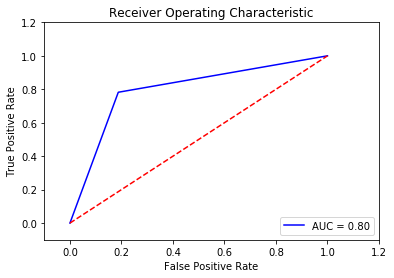

In [20]:
models = logreg_pipeline(df)

Compute correlation of each variable with outcome variable. Select top 100 highest positively-correlated variables to use as features.

Model performs worse now than when all variables are used as features. This is expected because outcome is a function of all 1000 variables in true relationship, so predictive power of 100 variables is not as high as 1000 variables.

In [21]:
correlations = []
for i in range(1000):
    corr_coeff = df['x'+str(i + 1)].corr(df.outcome)
    correlations.append((i, corr_coeff))
top_100 = sorted(correlations, key=lambda x: x[1])[-100:]

In [22]:
indices = ["x"+str(x[0]) for x in top_100]

In [23]:
df = df[['intercept'] + indices + ['z', 'pr', 'outcome']]


Train test split -- test size = 0.33
Baseline accuracy: 0.517
Accuracy: 0.582
AUC Score: 0.614
[[1051  606]
 [ 773  870]]


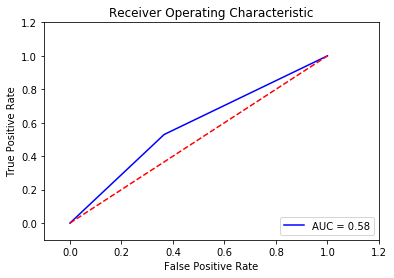

In [24]:
models = logreg_pipeline(df)

## Case 3: Regime change - intercept 
### DGP is stable over time, then the intercept suddenly changes; data leakage through non-temporal train-test split

Generate data for 5 periods with intercept change in period 2  
Dataset is in temporal order by default

In [25]:
frames = []
for i in [0,1]:
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 5, threshold = 0.8, betas = [1,2,3,4,5], intercept = 1)
    frames.append(period_df)
for i in [2,3,4]:
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 5, threshold = 0.8, betas = [1,2,3,4,5], intercept = 2) 
    frames.append(period_df)
df = pd.concat(frames)
df.to_csv('fake_data.csv')

Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...


Run pipeline using appropriate temporal train-test split. Model does well.


Time series split
Train periods:  [0] Test periods:  [1]
Baseline accuracy: 0.684
Accuracy: 0.998
AUC Score: 1.0
[[1384    1]
 [   3  612]]


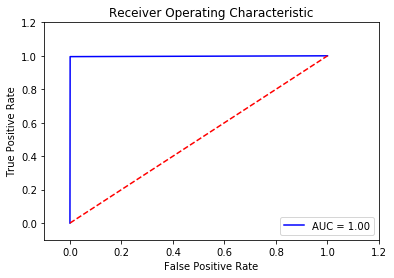

Train periods:  [0 1] Test periods:  [2]
Baseline accuracy: 0.688
Accuracy: 0.94
AUC Score: 1.0
[[1434    0]
 [ 119  447]]


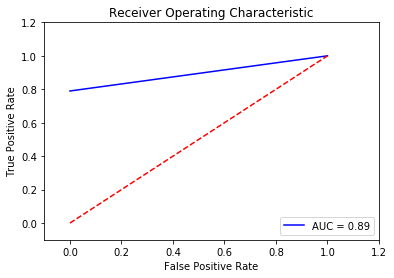

Train periods:  [0 1 2] Test periods:  [3]
Baseline accuracy: 0.698
Accuracy: 0.998
AUC Score: 1.0
[[1407    3]
 [   2  588]]


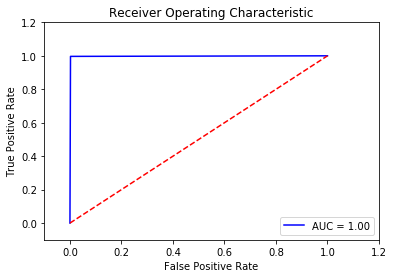

Train periods:  [0 1 2 3] Test periods:  [4]
Baseline accuracy: 0.7
Accuracy: 0.899
AUC Score: 1.0
[[1203    0]
 [ 202  595]]


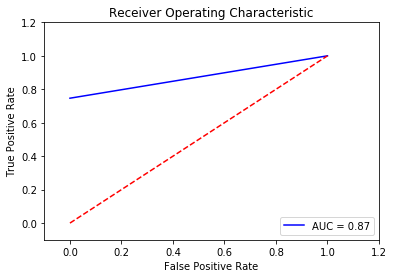

In [26]:
models = logreg_pipeline(df, temporal=True)

Put input file through randomization process, then run it through the pipeline. Model performs no better than random, as expected.

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Time series split
Train periods:  [0] Test periods:  [1]
Baseline accuracy: 0.684
Accuracy: 0.692
AUC Score: 0.501
[[1385    0]
 [ 615    0]]


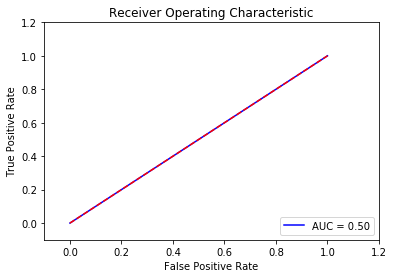

Train periods:  [0 1] Test periods:  [2]
Baseline accuracy: 0.688
Accuracy: 0.717
AUC Score: 0.509
[[1434    0]
 [ 566    0]]


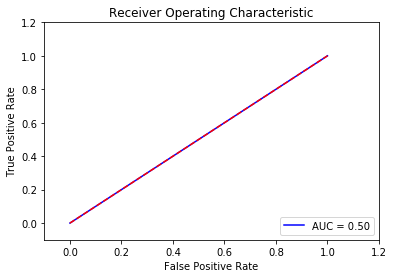

Train periods:  [0 1 2] Test periods:  [3]
Baseline accuracy: 0.698
Accuracy: 0.705
AUC Score: 0.516
[[1410    0]
 [ 590    0]]


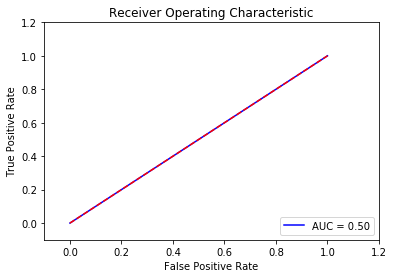

Train periods:  [0 1 2 3] Test periods:  [4]
Baseline accuracy: 0.7
Accuracy: 0.602
AUC Score: 0.498
[[1203    0]
 [ 797    0]]


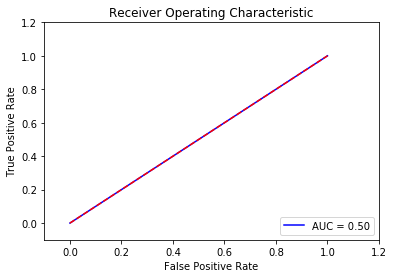

In [27]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # creates csv named fake_data_randomized.csv
models = logreg_pipeline(df_random, temporal = True)

Now, introduce data leakage by using non-temporal train-test split. Run this through the pipeline. Model performs well, as expected.


Train test split -- test size = 0.33
Baseline accuracy: 0.675
Accuracy: 0.983
AUC Score: 0.999
[[2245   30]
 [  25 1000]]


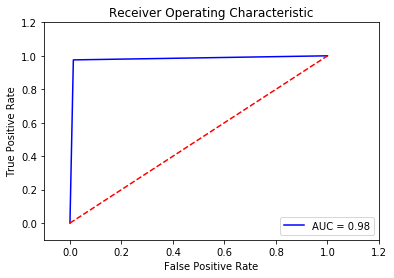

In [28]:
models = logreg_pipeline(df)

Observe model performance in each period of the test data.

In [29]:
model = models[0] # list only contains one dictionary because we ran a non-temporal pipeline

periods = np.sort(df.period.unique())

test_df = model['X_test']
test_df['y_test'] = model['y_test']
test_df['y_pred'] = model['y_pred']
test_df['probs'] = model['probs'][:, 1]

for i in periods:
    print("\nWhen test period is {}...".format(i))
    df_i = test_df[test_df.period == i]
    acc = metrics.accuracy_score(df_i.y_test, df_i.y_pred)
    auc = metrics.roc_auc_score(df_i.y_test, df_i.probs)
    print("Accuracy: {}".format(round(acc,5)))
    print("AUC: {}".format(round(auc,5)))


When test period is 0...
Accuracy: 0.98844
AUC: 0.99997

When test period is 1...
Accuracy: 0.98634
AUC: 1.0

When test period is 2...
Accuracy: 0.99849
AUC: 0.99999

When test period is 3...
Accuracy: 0.96789
AUC: 1.0

When test period is 4...
Accuracy: 0.97464
AUC: 1.0


Put the input file through randomization process, randomizing all columns except period and outcome. Again, introduce data leakage into the pipeline by using non-temporal train-test split. 

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Train test split -- test size = 0.33
Baseline accuracy: 0.683
Accuracy: 0.675
AUC Score: 0.524
[[2227    0]
 [1073    0]]


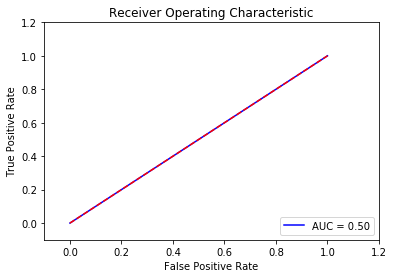

In [30]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # generates csv named "fake_data_randomized.csv"
models = logreg_pipeline(df_random)

Observe model performance in each period of the test data. We can see that this data leakage causes higher accuracy in period 2 when the data generating process changes, because information about the future has been leaked.

In [31]:
model = models[0] # list only contains one dictionary because we ran a non-temporal pipeline

periods = np.sort(df.period.unique())

test_df = model['X_test']
test_df['y_test'] = model['y_test']
test_df['y_pred'] = model['y_pred']
test_df['probs'] = model['probs'][:, 1]

for i in periods:
    print("\nWhen test period is {}....".format(i))
    df_i = test_df[test_df.period == i]
    acc = metrics.accuracy_score(df_i.y_test, df_i.y_pred)
    auc = metrics.roc_auc_score(df_i.y_test, df_i.probs)
    print("Accuracy: {}".format(round(acc, 5)))
    print("AUC: {}".format(round(auc,5)))


When test period is 0....
Accuracy: 0.67474
AUC: 0.49328

When test period is 1....
Accuracy: 0.68504
AUC: 0.54318

When test period is 2....
Accuracy: 0.73579
AUC: 0.49558

When test period is 3....
Accuracy: 0.68507
AUC: 0.46938

When test period is 4....
Accuracy: 0.59736
AUC: 0.5196
